# Autoencoder

Here I tried to implement an autoencoder to train on the MNIST dataset witout labels. The autoencoder will learn from the unlabeled data to categorize each number and recreate each number as realistic as possible.

In [1]:
import numpy as np
import os
import json

class NeuralNetwork:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def sigmoid_(x):
        return NeuralNetwork.sigmoid(x) * (1 - NeuralNetwork.sigmoid(x))
    @staticmethod
    def mae(answer, expected):
        return np.sum((answer - expected) ** 2)
    @staticmethod
    def mae_(answer, expected):
        return 2 * (answer - expected)
    @staticmethod
    def l1(answer, expected):
        return np.sum(np.abs(answer - expected))
    @staticmethod
    def l1_(answer, expected):
        return np.sign(answer - expected)
    @staticmethod
    def crossEntropy(answer, expected):
        return -np.sum(expected * np.log(answer)) - np.sum((1 - expected) * np.log(1 - answer))
    @staticmethod
    def crossEntropy_(answer, expected):
        return -expected / answer + (1 - expected) / (1 - answer)

    def __init__(self, *args, **kwargs):
        self.weight = [np.random.randn(args[i+1], args[i]) for i in range(len(args) - 1)]
        self.bias = [np.random.randn(args[i+1]) for i in range(len(args) - 1)]
        self.activation, self.activation_ = kwargs.get('activation', (NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_))
        self.errorFunc, self.errorFunc_ = kwargs.get('errorFunc', (NeuralNetwork.mae, NeuralNetwork.mae_))
        self.learnRate = kwargs.get('learnRate', 0.01)
        self.gradient_clip_threshold = kwargs.get('gradient_clip_threshold', None)

    def predict(self, inputData):
        """
        Give the set of all the activation values on the network when given a set of input data.
        `inputData` is a 2D numpy array, with its first index being the index of patches
        and the second index being the index of input neuron in one patch.
        Or: `inputData[k, i]` is the value of the i-th input neuron in the k-th patch.
        """
        if len(inputData.shape) == 1:
            inputData = inputData.reshape(1, inputData.shape[0])
        ans = [(None, inputData)]
        for i in range(len(self.bias)):
            before = np.matmul(ans[-1][1], self.weight[i].T) + self.bias[i]
            ans.append((before, self.activation(before)))
        return ans
    def apply(self, inputData):
        return self.predict(inputData)[-1][1]

    def backPropagate(self, predicted, outputErr):
        """
        Get the partial derivatives of the error function over the input values of each layer.
        `predicted` is the return value of `predict`.
        `outputErr` is the partial derivatives of the error function over the output values of the last layer.
        `outputErr[k, i]` is the partial derivative of the error function over the output value of the i-th neuron in the k-th patch.
        """
        ans = [outputErr]
        for i in reversed(range(len(self.bias))):
            gradient = np.matmul(ans[0] * self.activation_(predicted[i+1][0]), self.weight[i])
            if np.average(gradient * gradient) > self.gradient_clip_threshold * self.gradient_clip_threshold:
                gradient = gradient / np.sqrt(np.average(gradient * gradient)) * self.gradient_clip_threshold
            ans.insert(0, gradient)
        return ans

    def update(self, predicted, partials):
        batch_size = predicted[0][1].shape[0]
        bias_ = [partials[i+1] * self.activation_(predicted[i+1][0]) for i in range(len(self.bias))]
        weight_ = [np.matmul(np.transpose(bias_[i]), predicted[i][1]) / batch_size for i in range(len(self.weight))]
        for i in range(len(self.bias)):
            bias_[i] = np.mean(bias_[i], axis=0)
            self.bias[i] -= self.learnRate * bias_[i]
            self.weight[i] -= self.learnRate * weight_[i]

    def save_model(self, path, name):
        for i, weight in enumerate(self.weight):
            np.save(os.path.join(path, name + '_weight_' + str(i) + '.npy'), weight)
        for i, bias in enumerate(self.bias):
            np.save(os.path.join(path, name + '_bias_' + str(i) + '.npy'), bias)
        with open(os.path.join(path, name + '_config.json'), 'w') as f:
            json.dump({
                'activation': (self.activation.__name__, self.activation_.__name__),
                'errorFunc': (self.errorFunc.__name__, self.errorFunc_.__name__),
                'learnRate': self.learnRate,
                'gradient_clip_threshold': self.gradient_clip_threshold
            }, f, indent=2)
    
    def load_model(self, path, name, num_layers):
        self.weight = [np.load(os.path.join(path, name + '_weight_' + str(i) + '.npy')) for i in range(num_layers)]
        self.bias = [np.load(os.path.join(path, name + '_bias_' + str(i) + '.npy')) for i in range(num_layers)]
        with open(os.path.join(path, name + '_config.json'), 'r') as f:
            config = json.load(f)
            self.activation = getattr(__class__, config['activation'][0])
            self.activation_ = getattr(__class__, config['activation'][1])
            self.errorFunc = getattr(__class__, config['errorFunc'][0])
            self.errorFunc_ = getattr(__class__, config['errorFunc'][1])
            self.learnRate = config['learnRate']
            self.gradient_clip_threshold = config['gradient_clip_threshold']

784


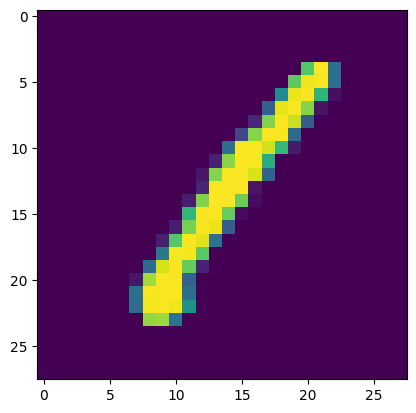

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt

with open("train.csv") as trainFile:
    train = list(csv.reader(trainFile))
    # label = np.array([train[i][0] for i in range(1, len(train))], dtype=np.int32)
    image = np.array([np.array(train[i][1:], dtype=float) / 255 for i in range(1, len(train))])

print(len(image[0]))
plt.imshow(image[0].reshape(28, 28))

## Data Augmentation

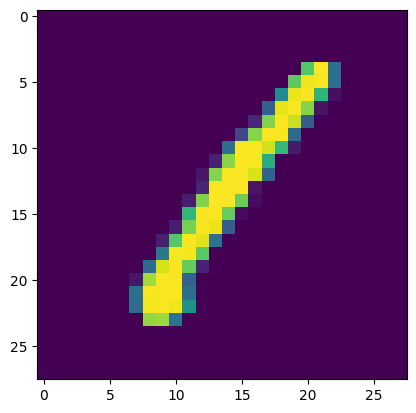

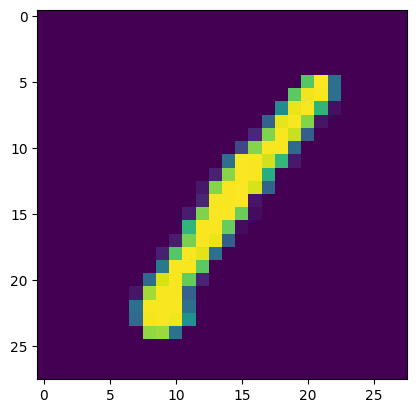

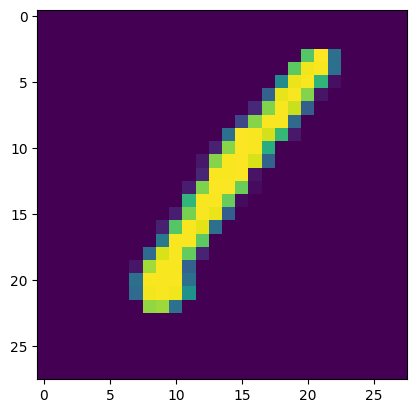

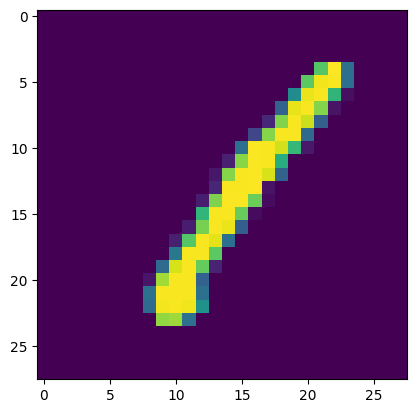

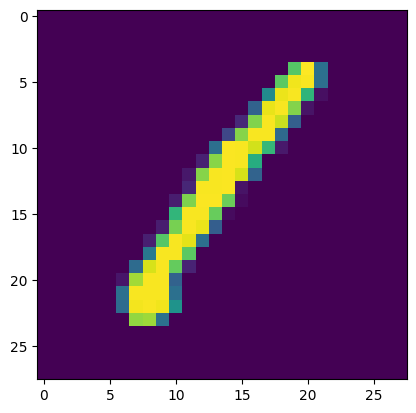

In [3]:
def augment(images):
    images = images.reshape(-1, 28, 28)
    image_roll_1 = np.roll(images, 1, axis=1)
    image_roll_2 = np.roll(images, -1, axis=1)
    image_roll_3 = np.roll(images, 1, axis=2)
    image_roll_4 = np.roll(images, -1, axis=2)
    return np.concatenate((images, image_roll_1, image_roll_2, image_roll_3, image_roll_4)).reshape(-1, 28 * 28)

image_lenth = len(image)
image = augment(image)
plt.imshow(image[0].reshape(28, 28))
plt.show()
plt.imshow(image[image_lenth].reshape(28, 28))
plt.show()
plt.imshow(image[image_lenth * 2].reshape(28, 28))
plt.show()
plt.imshow(image[image_lenth * 3].reshape(28, 28))
plt.show()
plt.imshow(image[image_lenth * 4].reshape(28, 28))
plt.show()

## Encoder + Decoder

In [4]:
encoder = NeuralNetwork(784, 40, 40, 20, activation=(NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_), gradient_clip_threshold=114514)
decoder = NeuralNetwork(20, 40, 40, 784, activation=(NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_), gradient_clip_threshold=114514)

In [5]:
def train(images, latent_lambda=0.1):
    param_enc = encoder.predict(images)
    latent = param_enc[-1][1]
    param_dec = decoder.predict(latent)
    error = NeuralNetwork.mae(param_dec[-1][1], images) + NeuralNetwork.l1(latent, 0.0)
    # print(error)
    partials_dec = decoder.backPropagate(param_dec, NeuralNetwork.mae_(param_dec[-1][1], images))
    latent_partial = latent_lambda * NeuralNetwork.l1_(latent, 0.0)
    partials_enc = encoder.backPropagate(param_enc, partials_dec[0] + latent_partial)
    encoder.update(param_enc, partials_enc)
    decoder.update(param_dec, partials_dec)
    return error

--- before training ---


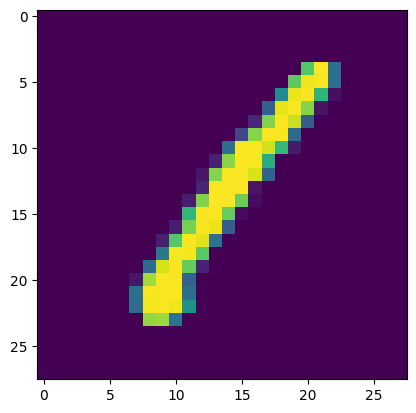

[[0.98173875 0.19196944 0.06110863 0.99734328 0.99995518 0.5284014
  0.99813575 0.24800085 0.5998903  0.98276851 0.9993178  0.00935407
  0.03907548 0.73521602 0.55062986]]


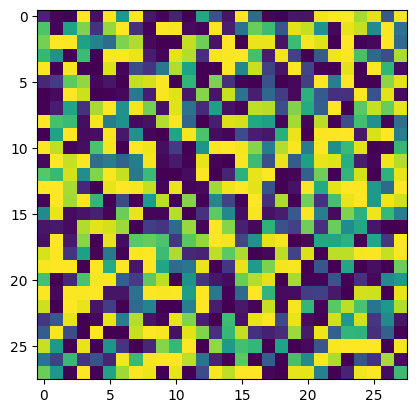

--- after training ---
[[0.9953146  0.17028627 0.04726981 0.99947837 0.99999522 0.86467629
  0.99493939 0.78171701 0.87174782 0.99489391 0.99885939 0.00909444
  0.01579927 0.27277759 0.10195828]]


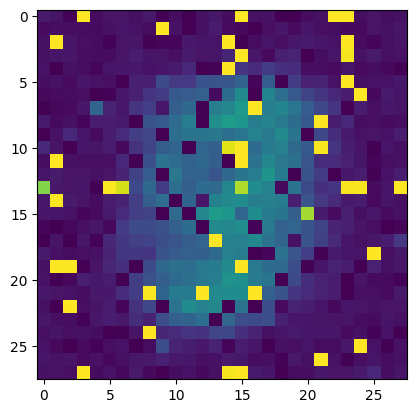

In [21]:
print("--- before training ---")
plt.imshow(image[0].reshape(28, 28))
plt.show()
print(encoder.apply(image[0:1]))
plt.imshow(decoder.apply(encoder.apply(image[0:1])).reshape(28, 28))
plt.show()

for i in range(1000):
    train(image[0:200])

print("--- after training ---")
print(encoder.apply(image[0:1]))
plt.imshow(decoder.apply(encoder.apply(image[0:1])).reshape(28, 28))
plt.show()

## Training the Autoencoder

100%|██████████| 25000/25000 [09:47<00:00, 42.54it/s]


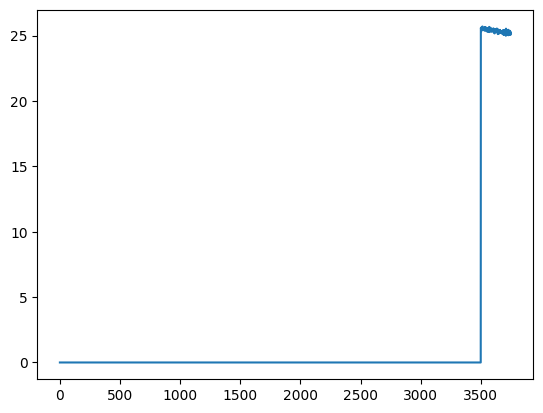

In [16]:
from tqdm import tqdm

N = 200000
BATCH_SIZE = 32

errors = np.zeros(int(N * (15/8)))

# for i in tqdm(range(N)):
#     errors[i] = train(image[np.random.randint(len(image), size=BATCH_SIZE)]) / BATCH_SIZE

# for i in tqdm(range(int(N / 2))):
#     errors[i+N] = train(image[np.random.randint(len(image), size=BATCH_SIZE * 2)]) / (BATCH_SIZE * 2)

# for i in tqdm(range(int(N / 4))):
#     errors[i+int(N*3/2)] = train(image[np.random.randint(len(image), size=BATCH_SIZE * 4)]) / (BATCH_SIZE * 4)

for i in tqdm(range(int(N / 8))):
    errors[i+int(N*7/4)] = train(image[np.random.randint(len(image), size=BATCH_SIZE * 8)]) / (BATCH_SIZE * 8)

BLOCK_AVERAGE = 100
errors = np.mean(errors.reshape(-1, BLOCK_AVERAGE), axis=1)
plt.plot(errors)
plt.show()

image index: 149095


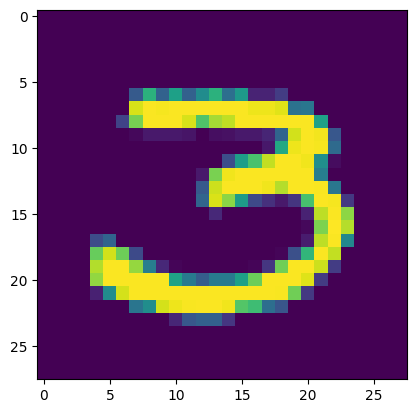

encoded: [[4.38775180e-01 3.50158049e-01 3.33737987e-01 3.08042761e-05
  3.82548679e-01 3.29487049e-04 7.09106156e-02 6.18660806e-02
  3.28350279e-02 3.94367367e-05 1.71191414e-01 3.17196120e-01
  1.09104657e-01 3.95239485e-01 1.01047282e-04 2.37017704e-01
  2.72190510e-04 2.88705240e-04 3.78789147e-01 1.90629763e-01]]


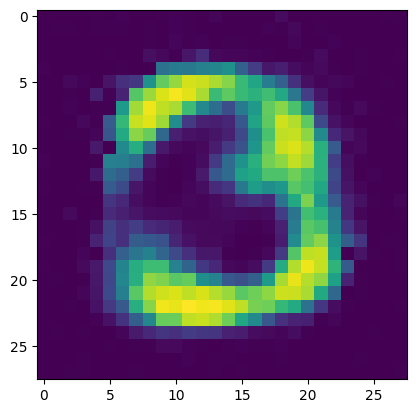

image index: 25803


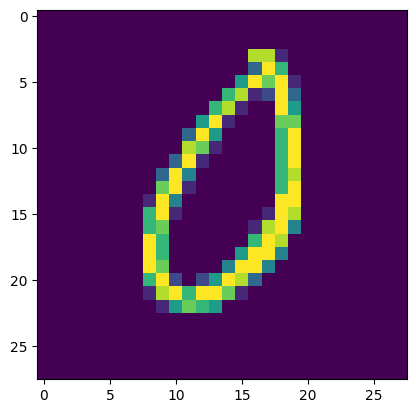

encoded: [[3.63549115e-01 4.43446303e-01 2.13767625e-01 2.26631592e-04
  2.79532620e-01 1.06930019e-04 5.84778862e-02 1.65053852e-01
  5.61234883e-01 6.20494522e-06 3.05886795e-01 3.16991107e-01
  3.15066838e-01 1.60521388e-01 5.66792174e-04 2.90973524e-01
  2.43264090e-04 9.83751534e-05 7.50333350e-02 2.39552362e-01]]


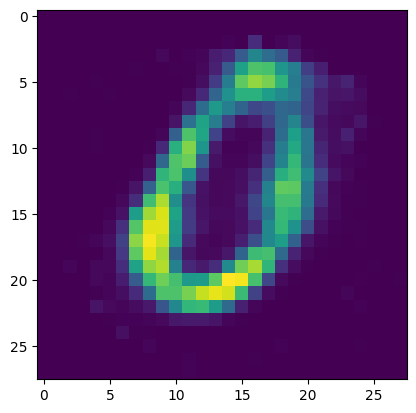

image index: 183691


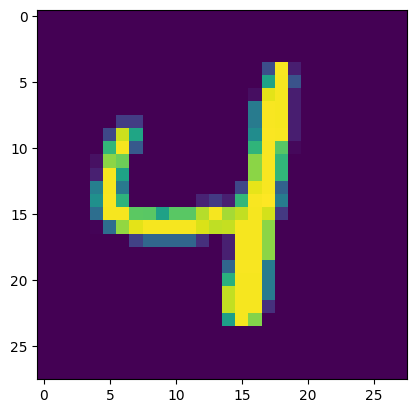

encoded: [[2.80058435e-01 2.67141931e-01 3.07408687e-01 2.82432905e-04
  7.97482971e-02 1.03552050e-04 3.52930101e-01 1.74778038e-01
  2.88221133e-01 5.18890255e-05 3.84501993e-01 3.58494067e-01
  1.91995130e-01 2.44967555e-01 1.82963766e-04 6.99558717e-01
  1.13972748e-03 1.21163510e-03 6.18675321e-02 4.21010703e-01]]


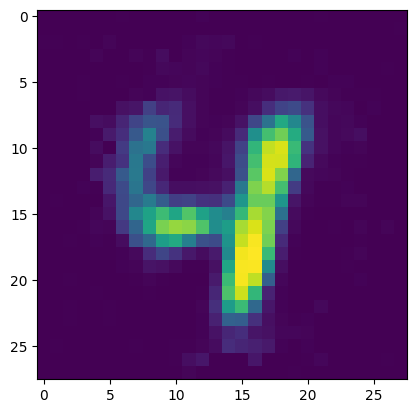

image index: 126249


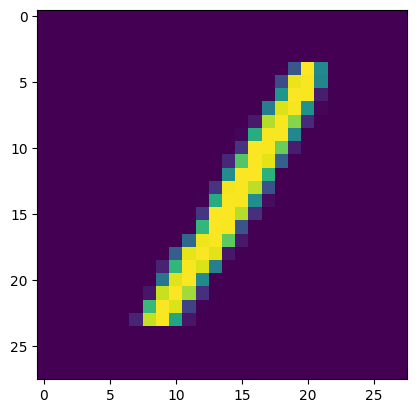

encoded: [[3.38763897e-01 1.25591479e-01 1.95348372e-01 3.33339023e-04
  5.08622040e-02 8.60847080e-05 1.24273493e-01 6.70344959e-01
  5.59726880e-02 1.30639845e-05 3.68250072e-01 1.82702068e-01
  3.43071430e-01 1.96368637e-01 4.08596044e-04 4.41423210e-01
  5.73458173e-04 1.65180128e-04 4.12891816e-01 8.88362095e-02]]


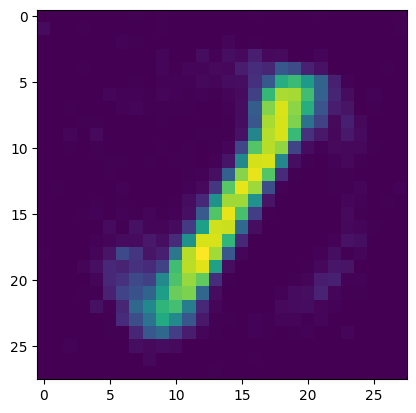

image index: 40916


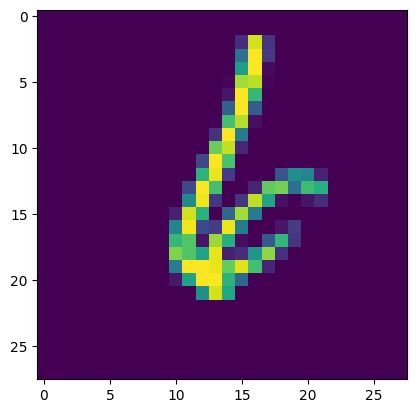

encoded: [[6.58669027e-02 1.75016190e-01 1.47402219e-01 1.85723716e-04
  1.30655863e-01 3.39728633e-05 1.23853555e-01 1.99527383e-01
  4.06646026e-01 5.94849642e-06 2.15568111e-01 2.42544789e-01
  3.82539554e-01 3.52295833e-01 4.64612244e-04 3.27212035e-01
  1.08195372e-04 6.77497005e-04 9.33172632e-02 1.54100929e-02]]


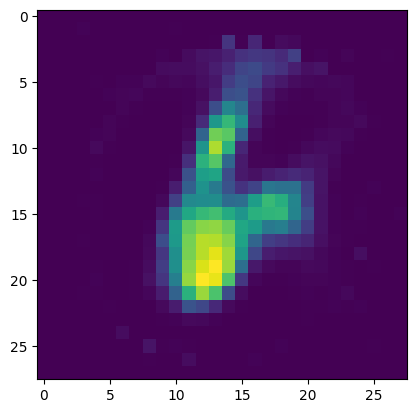

image index: 113608


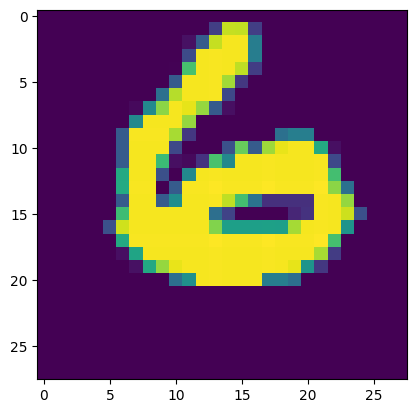

encoded: [[2.40081607e-01 2.27593364e-01 1.07518551e-01 2.44335701e-05
  6.97809858e-01 3.23756066e-04 2.48532591e-01 6.11715766e-02
  2.62970201e-01 7.98393494e-06 5.16875032e-01 6.45070340e-01
  9.57771932e-02 3.06890924e-01 9.23622535e-05 4.00936969e-01
  1.84468961e-04 2.74154421e-04 1.87303330e-01 2.58765612e-01]]


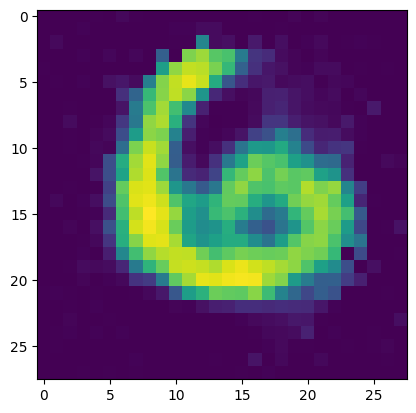

image index: 51674


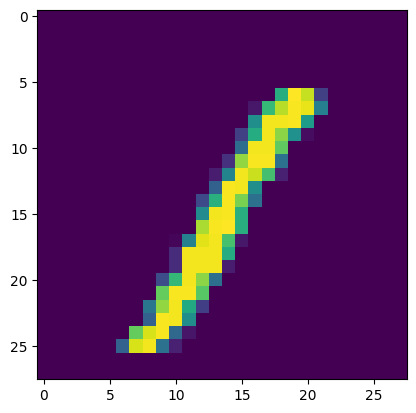

encoded: [[3.11762936e-01 1.53263856e-01 1.72129251e-01 2.98239381e-04
  5.09875095e-02 1.10908466e-04 1.57466132e-01 7.30557169e-01
  4.86901140e-02 9.99679057e-06 3.34885794e-01 2.21338841e-01
  2.99021485e-01 3.15676584e-01 3.89109040e-04 4.23680751e-01
  6.47197821e-04 1.55342546e-04 4.07458670e-01 9.64982134e-02]]


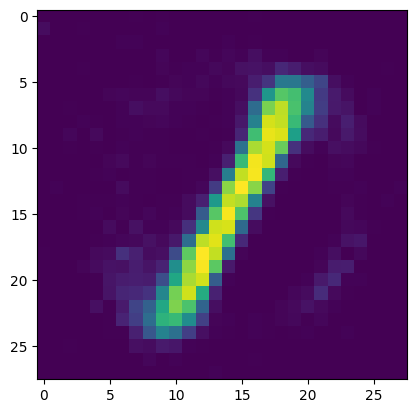

image index: 102054


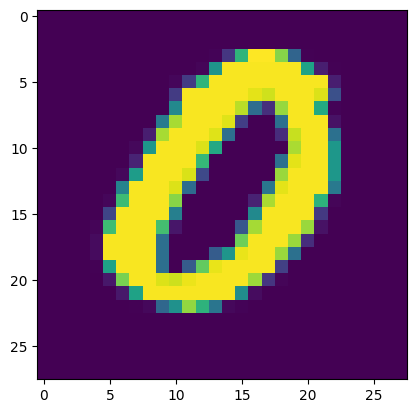

encoded: [[3.36357851e-01 6.28940308e-01 8.23071335e-02 5.92010460e-05
  5.22509732e-01 5.28556301e-04 4.50381900e-02 1.00281318e-01
  3.20108241e-01 2.62586279e-06 3.15358498e-01 5.80213805e-01
  1.75017617e-01 1.03032816e-01 2.26803497e-04 8.84494141e-02
  1.65248998e-04 1.26880267e-04 4.06707955e-02 2.27803596e-01]]


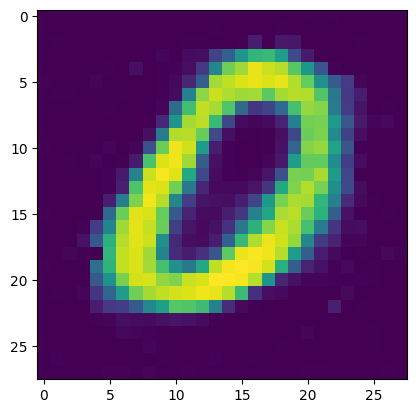

image index: 32727


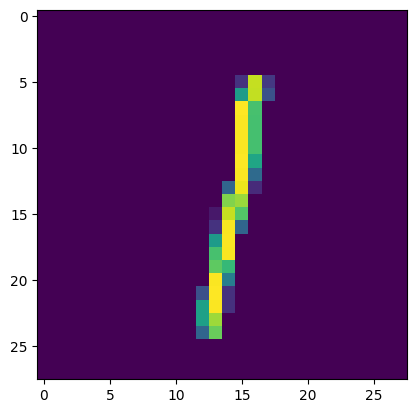

encoded: [[2.28381926e-01 1.25654128e-01 1.91830173e-01 4.28682803e-04
  2.30202156e-02 7.82831387e-05 4.68327111e-01 4.85044475e-01
  3.05283530e-01 1.64750564e-05 1.09931788e-01 1.24425920e-01
  2.05512507e-01 3.84696307e-01 4.44288348e-04 5.52815277e-01
  4.03133420e-04 2.60808527e-04 2.33340334e-01 8.02983958e-02]]


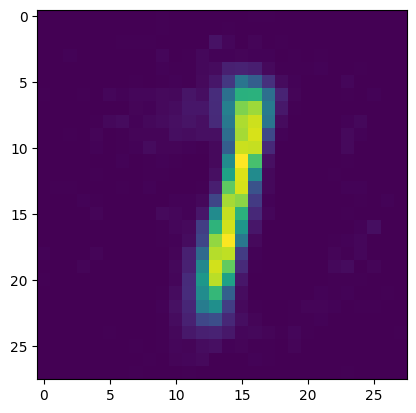

image index: 199624


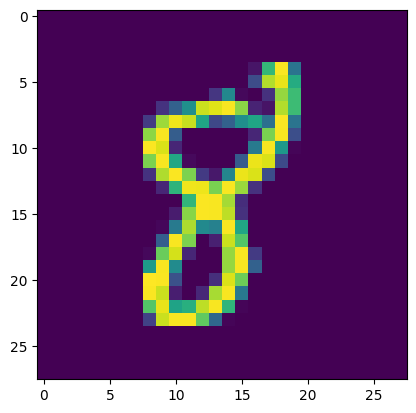

encoded: [[5.53913791e-01 1.45017726e-01 1.51606909e-01 2.76685607e-04
  1.07987344e-01 1.85317431e-04 2.31820356e-01 3.27176877e-01
  3.45268527e-01 1.05240316e-05 1.69252935e-01 3.29220572e-01
  2.15771045e-01 1.60996293e-01 4.60310879e-04 2.15761451e-01
  4.29655108e-04 1.55991505e-04 6.67987751e-02 2.80917590e-01]]


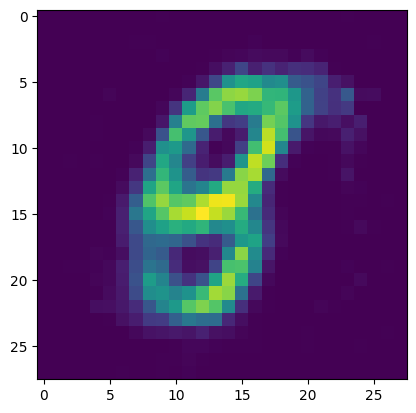

In [17]:
for i in range(10):
    index = np.random.randint(len(image))
    print("image index:", index)
    plt.imshow(image[index].reshape(28, 28))
    plt.show()
    print("encoded:", encoder.apply(image[index:index+1]))
    plt.imshow(decoder.apply(encoder.apply(image[index:index+1])).reshape(28, 28))
    plt.show()

In [18]:
encoder.save_model("encoder", "encoder")
decoder.save_model("decoder", "decoder")

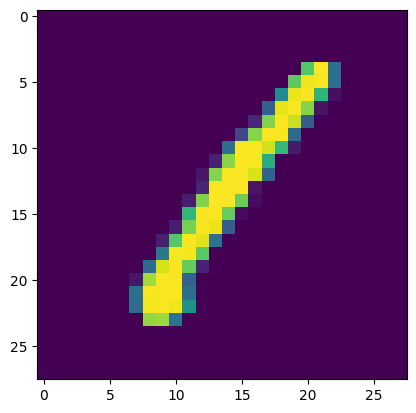

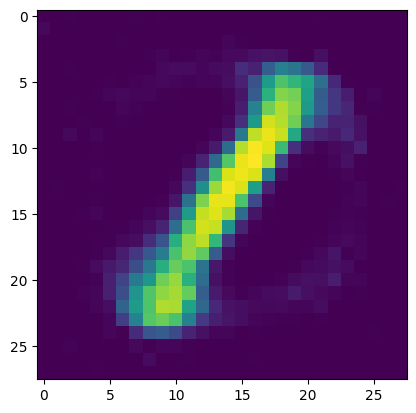

In [9]:
encoder = NeuralNetwork()
decoder = NeuralNetwork()
encoder.load_model("encoder", "encoder", 3)
decoder.load_model("decoder", "decoder", 3)
plt.imshow(image[0].reshape(28, 28))
plt.show()
plt.imshow(decoder.apply(encoder.apply(image[0])).reshape(28, 28))
plt.show()